In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')
active_directory = '/content/drive/MyDrive/Desktop/DP_Finetuning_Harnet_Submission'
os.chdir(active_directory)

Mounted at /content/drive


## IMPORT LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import pickle
from warnings import filterwarnings
from pandas.errors import SettingWithCopyWarning

filterwarnings("ignore", category=SettingWithCopyWarning)
filterwarnings('ignore', category=UserWarning)

## READ SUBJECT FILES

Each of the data-files contains 54 columns per row, the columns contain the following data:

-  1 timestamp (s)
- 2 activityID (see II.2. for the mapping to the activities)
- 3 heart rate (bpm)
- 4-20 IMU hand
- 21-37 IMU chest
- 38-54 IMU ankle

The IMU sensory data contains the following columns:

- 1 temperature (°C)
- 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
-  5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 3D-gyroscope data (rad/s)
- 11-13 3D-magnetometer data (μT)
- 14-17 orientation (invalid in this data collection)

16g acceleration hand -> indexes [4, 5, 6]

timestamp -> [0]

activity_id -> [1]

In [4]:
def read_subject_file(file_path:str)->pd.DataFrame:
    subject_name = file_path.split('/')[-1].rstrip('.dat')
    subject = pd.read_table(file_path, header=None, sep='\s+')
    return subject, subject_name

class DataProcessor:
  def __init__(self, subject_dataframe:pd.DataFrame, subject_name:str):
    self.subject_dataframe = subject_dataframe
    self.subject_name = subject_name
    self.acc_x_col = 'acc_x'
    self.acc_y_col = 'acc_y'
    self.acc_z_col = 'acc_z'
    self.timestamp = 'timestamp'
    self.activity_id = 'activity_id'

  def _extract_data(self)->pd.DataFrame:
    """
    Extract the relevant columns from the data
    """
    # timestamp, activity_id, 16g_acc_x, 16g_acc_y, 16g_acc_z
    raw_data = self.subject_dataframe.iloc[:, [0, 1, 4, 5, 6]]
    raw_data.columns = [self.timestamp , self.activity_id , self.acc_x_col, self.acc_y_col, self.acc_z_col]
    return raw_data

  def _handle_missing_values(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Used linear interpolation for the acceleration data
    """
    data[self.acc_x_col] = data[self.acc_x_col].interpolate(method='linear', limit_direction='both')
    data[self.acc_y_col] = data[self.acc_y_col].interpolate(method='linear', limit_direction='both')
    data[self.acc_z_col] = data[self.acc_z_col].interpolate(method='linear', limit_direction='both')
    return data

  def sorted_timestamps(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Sort the timestamps in ascending order
    """
    data = data.sort_values(by=self.timestamp, ascending=True).reset_index(drop=True)
    return data


  def downsample_from_100_to_30hz(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Downsample the data from 100Hz to 30Hz
    """

    data_copy = data.copy()
    data_copy.set_index(self.timestamp, inplace=True)
    data_copy.index = pd.to_timedelta(data_copy.index, unit="s")
    data_copy = data_copy.resample('0.0333s').agg({self.activity_id: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
                                        self.acc_x_col:"mean",
                                        self.acc_y_col:"mean",
                                        self.acc_z_col:"mean"}).reset_index()
    return data_copy


def activity_mapping(value:int):
  mapping_dict = {
        0: "other",
        1: "lying",
        2: "sitting",
        3: "standing",
        4: "walking",
        5: "running",
        6: "cycling",
        7: "Nordic walking",
        9: "watching TV",
        10: "computer work",
        11: "car driving",
        12: "ascending stairs",
        13: "descending stairs",
        16: "vacuum cleaning",
        17: "ironing",
        18: "folding laundry",
        19: "house cleaning",
        20: "playing soccer",
        24: "rope jumping"
   }
  return mapping_dict.get(value, 'Unknown')


def create_sliding_windows(dataframe, window_length_sec, sampling_rate_hz, step_duration_sec):
  import scipy.stats as stats


  N_FEATURES = 3
  window_length_samples = int(window_length_sec * sampling_rate_hz)
  step_duration_samples = int(step_duration_sec * sampling_rate_hz)
  windows = []
  labels = []
  for i in range(0, len(dataframe)-window_length_samples, step_duration_samples):
    x = dataframe['acc_x'].values[i: i + window_length_samples]
    y = dataframe['acc_y'].values[i: i + window_length_samples]
    z = dataframe['acc_z'].values[i: i + window_length_samples]
    window = np.array([x, y, z])
    label = dataframe['activity_id'][i: i + window_length_samples]

    windows.append(window)
    labels.append(label)

  windows = np.asarray(windows).reshape(-1, N_FEATURES, window_length_samples, )
  labels = np.asarray(labels)

  return windows, labels



def clean_window_labels(window_X, window_y):
  """
  Remove the windows that have activity id = 0 ratio > 0.5
  """
  clean_window_X = []
  clean_window_y = []

  for i in range(len(window_y)):
    if np.sum(window_y[i] == 0) / len(window_y[i]) < 0.5:
      clean_window_X.append(window_X[i])
      clean_window_y.append(window_y[i])

  clean_window_X = np.array(clean_window_X)
  clean_window_y = np.array(clean_window_y)

  return clean_window_X, clean_window_y


def majority_voting(window_y):
  """
  Most frequent activity id in a window
  """
  from scipy import stats as st

  major_window_y = st.mode(window_y, axis=1).mode
  return major_window_y


def reshaped_windows(window_X, window_y):
  """
  Reshape the windows to fit the model (n_windows, n_features, n_timestamps)
  """
  window_X = window_X.reshape(window_X.shape[0], window_X.shape[2], window_X.shape[1])
  window_y = window_y.reshape(window_y.shape[0], )
  return window_X, window_y


def activity_filter(window_X, window_y):
  """
  Filtering the activities that everybody does. (1, 2, 3, 4, 12, 13, 16, 17)
  """
  filtered_window_X = []
  filtered_window_y = []

  valid_indices = (
            (window_y == 1) | (window_y == 2) | (window_y == 3) | (window_y == 4) | (window_y == 12) | (window_y == 13) | (window_y == 16) | (window_y == 17)
        )

  filtered_window_X = window_X[valid_indices]
  filtered_window_y = window_y[valid_indices]

  return filtered_window_X, filtered_window_y



In [5]:
file_dir = 'Protocol'
subject_raw_files = os.listdir(file_dir)

In [6]:
subject_arr_Xs = []
subject_arr_ys = []
subject_names = []

window_length_sec = 10
step_duration_sec = 5
sampling_rate_hz = 30
overlap_ratio = round((100*(window_length_sec-step_duration_sec)/window_length_sec), 2)


print(f'WINDOW LENGTH in SAMPLES: {int(window_length_sec * sampling_rate_hz)}')
print(f'STEP DURATION in SAMPLES: {int(step_duration_sec * sampling_rate_hz)}')
print(f'OVERLAPPING WINDOW RATIO: {overlap_ratio}%')


for f in subject_raw_files:
  file_path = os.path.join(file_dir, f)
  subject, subject_name = read_subject_file(file_path)
  if subject_name != 'subject109':
    print('-----------------------------------------------------------')
    print(f'Data preprocessing is starting for {subject_name}...')
    processor = DataProcessor(subject, subject_name)
    raw_data = processor._extract_data()

    subject_df = processor._handle_missing_values(raw_data)   # Missing axes values are filled by applying linear interpolation
    subject_df = processor.sorted_timestamps(subject_df)    # Update if the timestamps is not ascending
    downsampled_subject_df = processor.downsample_from_100_to_30hz(subject_df)    # Downsample the data from 100Hz to 30Hz

    win_X, win_y = create_sliding_windows(downsampled_subject_df, window_length_sec=window_length_sec, sampling_rate_hz=sampling_rate_hz, step_duration_sec=step_duration_sec)
    clean_win_X, clean_win_y = clean_window_labels(win_X, win_y)    # Remove the windows that have activity id = 0 ratio > 0.5
    major_win_y = majority_voting(clean_win_y)    # Majority voting for the labels in a window
    filtered_window_X, filtered_window_y = activity_filter(clean_win_X, major_win_y)   # Filtering the activities that everybody does. (1, 2, 3, 4, 12, 13, 16, 17)

    print(f'Final remaining shapes X: {filtered_window_X.shape}, y: {filtered_window_y.shape}')

    subject_arr_Xs.append(filtered_window_X)
    subject_arr_ys.append(filtered_window_y)
    subject_names.append(subject_name)


all_subject_infos = list(zip(subject_names, subject_arr_Xs, subject_arr_ys))

WINDOW LENGTH in SAMPLES: 300
STEP DURATION in SAMPLES: 150
OVERLAPPING WINDOW RATIO: 50.0%
-----------------------------------------------------------
Data preprocessing is starting for subject101...
Final remaining shapes X: (345, 3, 300), y: (345,)
-----------------------------------------------------------
Data preprocessing is starting for subject102...
Final remaining shapes X: (373, 3, 300), y: (373,)
-----------------------------------------------------------
Data preprocessing is starting for subject103...
Final remaining shapes X: (348, 3, 300), y: (348,)
-----------------------------------------------------------
Data preprocessing is starting for subject104...
Final remaining shapes X: (364, 3, 300), y: (364,)
-----------------------------------------------------------
Data preprocessing is starting for subject105...
Final remaining shapes X: (379, 3, 300), y: (379,)
-----------------------------------------------------------
Data preprocessing is starting for subject106...

In [ ]:
activity_dfs = []

for sb_n, Xs, ys in all_subject_infos:
  print(f'Subject {sb_n}: {np.unique(ys, return_counts=True)}')

  subject_activities = np.vectorize(activity_mapping)(ys)
  activity_counts = pd.Series(subject_activities).value_counts(normalize=True).reset_index()
  activity_counts.columns = ['Activity', 'Ratio']
  activity_counts['Ratio'] = activity_counts['Ratio'] * 100
  activity_counts['Subject'] = sb_n

  activity_dfs.append(activity_counts)

final_activity_df = pd.concat(activity_dfs, axis=0, ignore_index=True)

Subject subject101: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([55, 47, 43, 45, 33, 29, 46, 47]))
Subject subject102: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([47, 45, 51, 65, 34, 31, 42, 58]))
Subject subject103: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([44, 57, 41, 58, 21, 30, 41, 56]))
Subject subject104: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([47, 51, 50, 64, 33, 29, 40, 50]))
Subject subject105: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([48, 53, 45, 64, 29, 25, 49, 66]))
Subject subject106: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([46, 46, 49, 51, 27, 22, 42, 76]))
Subject subject107: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([51, 25, 51, 67, 36, 22, 43, 60]))
Subject subject108: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([48, 46, 50, 63, 23, 19, 49, 66]))


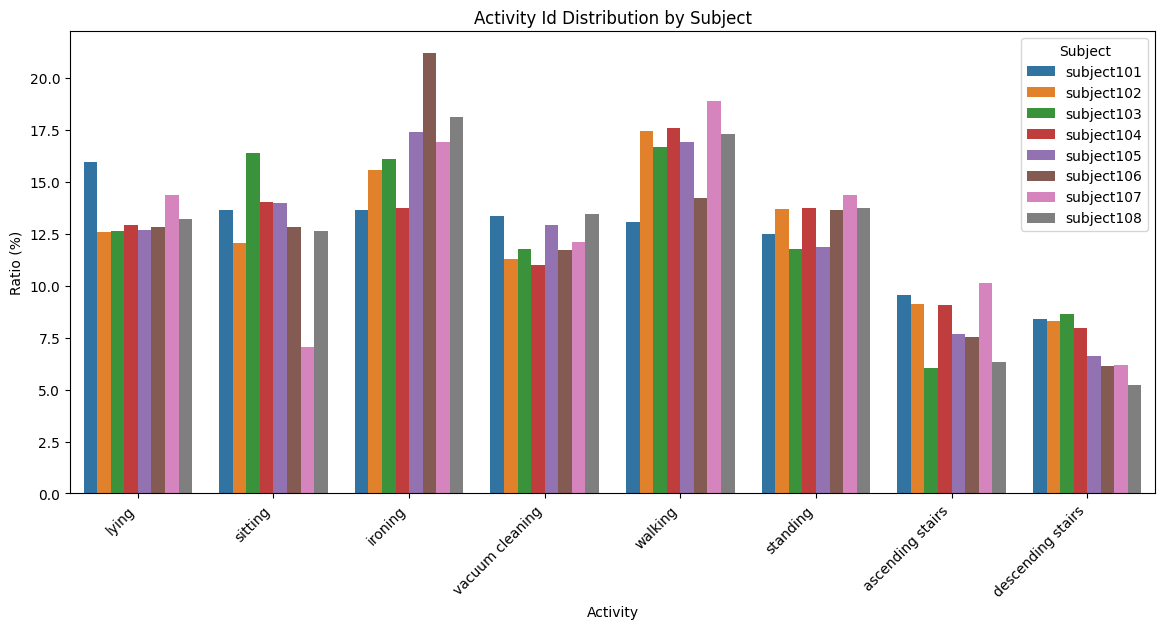

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=final_activity_df, x='Activity', y='Ratio', hue='Subject')
plt.xlabel('Activity')
plt.ylabel('Ratio (%)')
plt.title('Activity Id Distribution by Subject')
plt.xticks(rotation=45, ha='right')
plt.show();

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def get_pretrained_harnet(class_num, model_name = 'harnet10'):
    repo = 'OxWearables/ssl-wearables'
    model = torch.hub.load(repo, model_name, class_num=class_num, pretrained=True, force_reload=True)
    return model

def train(model, train_loader, optimizer, criterion, epoch, device, is_dp=False, privacy_engine=None, delta=None):
  model.train()
  total_loss = 0
  correct = 0
  total_samples = 0
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * data.size(0)
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size(0)
      if batch_idx % 10 == 0:
          if is_dp and privacy_engine:
              epsilon = privacy_engine.get_epsilon(delta)
              print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                    f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                    f"Loss: {loss.item():.6f}\tEpsilon: {epsilon:.2f}")
          else:
              print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                    f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                    f"Loss: {loss.item():.6f}")

  avg_loss = total_loss / total_samples
  accuracy = 100. * correct / total_samples
  print(f"Epoch {epoch} - Training: Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
  return avg_loss, accuracy


def evaluate(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0
  correct = 0
  all_preds = []
  all_targets = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item() * data.size(0)
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()
          all_preds.extend(pred.cpu().numpy())
          all_targets.extend(target.cpu().numpy())
  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
  print(f"Evaluation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({accuracy:.2f}%), F1-score: {f1:.4f}\n")
  return test_loss, accuracy, f1


class CustomScaler:
  """
  A wrapper for scikit-learn's StandardScaler that handles both 2D and 3D NumPy arrays.
  For 3D data, it reshapes to 2D, scales, and then reshapes back.
  """
  def __init__(self):
      self._scaler = StandardScaler()
      self._is_fitted = False
      self._original_input_dims = None # To store the dimensionality of data it was fit on
  def fit(self, data: np.ndarray):
      self._original_input_dims = data.ndim
      if self._original_input_dims == 2:
          self._scaler.fit(data)
      elif self._original_input_dims == 3:
          n_samples, n_timesteps, n_features = data.shape
          reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
          self._scaler.fit(reshaped_data)
      else:
          raise ValueError("Input data must have 2 or 3 dimensions for scaling.")
      self._is_fitted = True
      return self
  def fit_transform(self, data: np.ndarray) -> np.ndarray:
      self._original_input_dims = data.ndim

      if self._original_input_dims == 2:
          scaled_data = self._scaler.fit_transform(data)
      elif self._original_input_dims == 3:
          n_samples, n_timesteps, n_features = data.shape
          # Reshape 3D data to 2D for scaling
          reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
          scaled_reshaped_data = self._scaler.fit_transform(reshaped_data)
          # Reshape scaled data back to original 3D shape
          scaled_data = scaled_reshaped_data.reshape((n_samples, n_timesteps, n_features))
      else:
          raise ValueError("Input data must have 2 or 3 dimensions for scaling.")

      self._is_fitted = True
      return scaled_data

  def transform(self, data: np.ndarray) -> np.ndarray:
    if not self._is_fitted:
      raise RuntimeError("Scaler has not been fitted. Call fit_transform first.")
    if data.ndim != self._original_input_dims:
      raise ValueError(f"Input data has {data.ndim} dimensions, but scaler was fitted on "
                            f"data with {self._original_input_dims} dimensions.")
    if self._original_input_dims == 2:
        scaled_data = self._scaler.transform(data)
    elif self._original_input_dims == 3:
        n_samples, n_timesteps, n_features = data.shape
        reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
        scaled_reshaped_data = self._scaler.transform(reshaped_data)
        scaled_data = scaled_reshaped_data.reshape((n_samples, n_timesteps, n_features))
    else:
        raise ValueError("Input data must have 2 or 3 dimensions.")

    return scaled_data

def get_data_loader(X_test, y_test, BATCH_SIZE, shuffle=False):
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle)
  return test_loader

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False):
      self.patience = patience
      self.delta = delta
      self.best_score = None
      self.early_stop = False
      self.counter = 0
      self.best_model_state = None
      self.verbose = verbose
      self.best_epoch = 0
  def __call__(self, val_loss, model, epoch):
      score = -val_loss
      if self.best_score is None:
          self.best_score = score
          self.best_model_state = copy.deepcopy(model.state_dict())
          self.best_epoch = epoch
      elif score < self.best_score + self.delta:
          self.counter += 1
          if self.verbose:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
          if self.counter >= self.patience:
              self.early_stop = True
      else:
          self.best_score = score
          self.best_model_state = copy.deepcopy(model.state_dict())
          self.best_epoch = epoch
          self.counter = 0

  def load_best_model(self, model):
      if self.best_model_state:
          model.load_state_dict(self.best_model_state)



def plot_distribution(arr:np.ndarray, title:str):
  pd.Series(arr).value_counts(normalize=True).plot(kind='bar')
  plt.title(title)
  plt.show()


In [ ]:
def fold_plot(fold_train_accuracies, fold_val_accuracies, val_subjects):
  import matplotlib.pyplot as plt
  import math
  # Get the list of train and val accuracies
  acc_list_zipped = list(zip(fold_train_accuracies, fold_val_accuracies, val_subjects))

  # Get the total number of folds to plot
  num_folds = len(acc_list_zipped)

  # --- Subplot Layout Calculation ---
  ncols = 2
  nrows = math.ceil(num_folds / ncols)

  # --- Create the Figure and Subplots ---
  fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows))
  fig.suptitle('Training vs. Validation Accuracy Across Folds', fontsize=16, y=1.02)
  axes = axes.flatten()


  # --- Loop and Plot on Each Subplot ---
  for i, (tr_acc, vl_acc, vl_subjects) in enumerate(acc_list_zipped):
      ax = axes[i] # Get the current axis
      ax.plot(tr_acc, label='Train Accuracy', color='royalblue')
      ax.plot(vl_acc, label='Validation Accuracy', color='darkorange')
      ax.set_title(f'Fold: {i + 1} for  Validation Subjects {vl_subjects}')
      ax.set_xlabel('Epoch')
      ax.set_ylabel('Accuracy')
      ax.legend()
      ax.grid(True, linestyle='--', alpha=0.6)

  # --- Clean Up and Display ---
  # If the number of folds is odd, the last subplot in the grid will be empty.
  # This loop hides any unused subplots.
  for i in range(num_folds, len(axes)):
      axes[i].axis('off')

  # Adjusts subplot params so that subplots are nicely fit in the figure.
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  return fig


def plot_epochs(train_accs, val_accs, val_subj):
  import matplotlib.pyplot as plt
  epochs = np.arange(1, len(train_accs) + 1)
  fig, ax = plt.subplots()
  ax.plot(epochs, train_accs, label='Train Accuracy', color='royalblue')
  ax.plot(epochs, val_accs, label='Validation Accuracy', color='darkorange')
  ax.set_title(f'Training vs. Validation Accuracy for Validation Subjects {val_subj}')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_xticks(epochs)
  ax.legend()
  ax.grid(True, linestyle='--', alpha=0.6)
  return fig


def remove_module_prefix(state_dict):
    return {k.replace("_module.", ""): v for k, v in state_dict.items()}


## FINE TUNING of CLASSIFIER HEADS



In [ ]:
#%pip install opacus

In [ ]:

import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, LeaveOneGroupOut
import torch.nn as nn
import copy
from itertools import product
from opacus import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

label_encoder = LabelEncoder()

reports_save = True

X_combined = []
y_combined = []
subject_groups_combined = []

for sb_name, Xs, ys in all_subject_infos:
  X_combined.extend(Xs)
  y_combined.extend(ys)
  subject_groups_combined.extend([sb_name] * len(ys))

X_combined = np.array(X_combined)
y_combined = np.array(y_combined)
subject_groups_combined = np.array(subject_groups_combined)

label_encoder.fit(y_combined)
encoded_y_combined_raw = label_encoder.transform(y_combined)

# Considering acitivities distribution
outer_skf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)


EPOCHS = 20
BATCH_SIZE_LIST = [32]
LRATE_LIST = [1e-3]


parameter_pairs = list(product(BATCH_SIZE_LIST, LRATE_LIST))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CLASSES = len(label_encoder.classes_)
g_noise_multp = 1.0
C_value = 1.0
noise_scale = g_noise_multp * C_value
DELTA = 1e-5

print(f'Noise scale: {noise_scale}')

for BATCH_SIZE, LRATE in parameter_pairs:
  print('-------------------------------------------------------------------------------------------------')
  print(f'Batch size: {BATCH_SIZE}, Learning rate: {LRATE}')
  print('-------------------------------------------------------------------------------------------------')

  test_outer_subject_list = []
  test_outer_losses = []
  test_outer_accuracies = []
  test_outer_f1s = []
  best_fold_train_losses = []
  best_fold_val_losses = []
  best_fold_val_f1s = []
  best_fold_train_accuracies = []
  best_fold_val_accuracies = []
  best_fold_epochs = []
  l_rates = []
  batch_sizes = []
  fold_details = {"Test Subjects": [], "Batch_Size": BATCH_SIZE, "Learning_Rate": LRATE, "Epoch_Results": []}
  for outer_fold, (train_outer_index, test_outer_index) in enumerate(outer_skf.split(X_combined, encoded_y_combined_raw, subject_groups_combined), start=1):
    print(f'Outer Fold {outer_fold} is starting ...')
    X_outer_train_val, X_outer_test = X_combined[train_outer_index], X_combined[test_outer_index]
    y_outer_train_val, y_outer_test = encoded_y_combined_raw[train_outer_index], encoded_y_combined_raw[test_outer_index]

    train_val_subject_groups = subject_groups_combined[train_outer_index]

    test_outer_subjects = np.unique(subject_groups_combined[test_outer_index] )
    train_outer_subjects = np.unique(train_val_subject_groups)

    print(f'Test subjects: {test_outer_subjects}')
    print(f'Train-Validation subjects: {train_outer_subjects}')

    # Leave One Group Out for inner fold
    inner_skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

    fold_val_subjects = []
    fold_train_subjects = []
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_epochs = []
    fold_best_epochs = []
    fold_f1_scores = []

    for fold, (train_index, val_index) in enumerate(inner_skf.split(X_outer_train_val, y_outer_train_val, train_val_subject_groups), start=1):
      print(f'Fold {fold} is starting ...')

      X_train, X_val = X_outer_train_val[train_index], X_outer_train_val[val_index]
      y_train, y_val = y_outer_train_val[train_index], y_outer_train_val[val_index]

      val_subjects = np.unique(train_val_subject_groups[val_index])
      train_subjects = np.unique(train_val_subject_groups[train_index])
      print(f'Validation subjects : {val_subjects}')
      print(f'Train subjects: {train_subjects}')

      scaler = CustomScaler()
      scaled_X_train = scaler.fit_transform(X_train)
      scaled_X_val = scaler.transform(X_val)

      train_data_loader = get_data_loader(scaled_X_train, y_train, BATCH_SIZE=BATCH_SIZE, shuffle=True)
      val_data_loader = get_data_loader(scaled_X_val, y_val, BATCH_SIZE=BATCH_SIZE, shuffle=False)

      model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      model.to(device)

      for name, param in model.named_parameters():
        if name.startswith('classifier'):
          param.requires_grad = True
        else:
          param.requires_grad = False

      optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LRATE, weight_decay=0.01)
      criterion = nn.CrossEntropyLoss()
      early_stopping = EarlyStopping(patience=10, verbose=True)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
      privacy_engine = PrivacyEngine(secure_mode=False)
      model, optimizer, train_data_loader = privacy_engine.make_private(
          module=model,
          optimizer=optimizer,
          data_loader=train_data_loader,
          noise_multiplier=g_noise_multp,
          max_grad_norm=C_value
      )

      val_losses = []
      val_accuracies = []
      val_f1s = []
      train_losses = []
      train_accuracies = []
      epochs_list = []

      epoch_results = {"epoch": [], "val_subjects":val_subjects, "noise_scale":[], "achieved_epsilon": [],"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
      best_val_loss = float('inf')
      best_model_state = None
      best_scaler = None
      best_epoch = None
      for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, epoch, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        epochs_list.append(epoch)

        a_epsilon = round(privacy_engine.get_epsilon(DELTA), 3)
        epoch_results["noise_scale"].append(noise_scale)
        epoch_results["achieved_epsilon"].append(a_epsilon)
        print(f'Epsilon Spent: {a_epsilon}, Noise_Scale: {noise_scale}')

        epoch_results["epoch"].append(epoch)
        epoch_results["train_loss"].append(train_loss)
        epoch_results["train_acc"].append(train_acc)
        epoch_results["val_loss"].append(val_loss)
        epoch_results["val_acc"].append(val_acc)
        epoch_results["val_f1"].append(val_f1)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_state = copy.deepcopy(model.state_dict())
          best_epoch = epoch
          best_scaler = copy.deepcopy(scaler)

        early_stopping(val_loss, model, epoch)
        if early_stopping.early_stop:
          print("Early stopping")
          break

      # Scores are added based on the best epoch considering early stopping to prevent overfitting
      best_epoch_index = best_epoch - 1   # Since epoch loop starts with 1

      # TEST SUBJECTS EVALUATION
      print(f' #### Test Evaluation is starting for {test_outer_subjects} #### ')
      final_val_model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      final_val_model.load_state_dict(remove_module_prefix(best_model_state))
      final_val_model.to(device)

      scaled_X_outer_test = best_scaler.transform(X_outer_test)
      test_data_loader = get_data_loader(scaled_X_outer_test, y_outer_test, BATCH_SIZE=BATCH_SIZE, shuffle=False)
      test_loss, test_acc, test_f1 = evaluate(final_val_model, test_data_loader, criterion, device)

      test_outer_subject_list.append(test_outer_subjects)
      test_outer_losses.append(test_loss)
      test_outer_accuracies.append(test_acc)
      test_outer_f1s.append(test_f1)
      best_fold_train_losses.append(train_losses[best_epoch_index])
      best_fold_val_losses.append(val_losses[best_epoch_index])
      best_fold_val_f1s.append(val_f1s[best_epoch_index])
      best_fold_train_accuracies.append(train_accuracies[best_epoch_index])
      best_fold_val_accuracies.append(val_accuracies[best_epoch_index])
      best_fold_epochs.append(epochs_list[best_epoch_index])
      fold_train_subjects.append(train_subjects)
      fold_val_subjects.append(val_subjects)
      fold_details['Test Subjects'].append(test_outer_subjects)
      fold_details['Epoch_Results'].append(epoch_results)
      batch_sizes.append(BATCH_SIZE)
      l_rates.append(LRATE)


directory_name = 'downsampled_results_DP'
os.makedirs(directory_name, exist_ok=True)


today_time = dt.date.today().strftime("%Y%m%d")
vers = f'{window_length_sec}_{sampling_rate_hz}_{overlap_ratio}_{today_time}'

fold_details_df = pd.DataFrame(fold_details)

summary_df = pd.DataFrame({'Test_Subjects':test_outer_subject_list,
                           "Test_Losses":test_outer_losses,
                           "Best_Val_Losses":best_fold_val_losses,
                           "Best_Train_Losses":best_fold_train_losses,
                           "Test_Accuracies":test_outer_accuracies,
                           "Best_Val_Accuracies":best_fold_val_accuracies,
                           "Best_Train_Accuracies":best_fold_train_accuracies,
                           "Test_F1s":test_outer_f1s,
                           "Best_Val_F1s":best_fold_val_f1s,
                           "Best_Val_Epochs":best_fold_epochs,
                           "Batch_Size":batch_sizes,
                           "Learning_Rate":l_rates
                           })

if reports_save:
  fold_details_df.to_csv(f'{directory_name}/fold_details_DP_CH_NS_{noise_scale}_{vers}_Split_4-2-2.csv')
  summary_df.to_csv(f'{directory_name}/summary_df_DP_CH_NS_{noise_scale}_{vers}_Split_4-2-2.csv')


Noise scale: 10.0
-------------------------------------------------------------------------------------------------
Batch size: 32, Learning rate: 0.001
-------------------------------------------------------------------------------------------------
Outer Fold 1 is starting ...
Test subjects: ['subject102' 'subject107']
Train-Validation subjects: ['subject101' 'subject103' 'subject104' 'subject105' 'subject106'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1416 (0%)]	Loss: 8.127763
Train Epoch: 1 [240/1416 (22%)]	Loss: 9.218986
Train Epoch: 1 [580/1416 (44%)]	Loss: 7.798280
Train Epoch: 1 [1050/1416 (67%)]	Loss: 9.284518
Train Epoch: 1 [1440/1416 (89%)]	Loss: 8.501242
Epoch 1 - Training: Average loss: 8.0615, Accuracy: 12.46%
Evaluation set: Average loss: 8.1701, Accuracy: 101/743 (13.59%), F1-score: 0.0988

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1416 (0%)]	Loss: 5.793286
Train Epoch: 2 [270/1416 (22%)]	Loss: 7.129116
Train Epoch: 2 [680/1416 (44%)]	Loss: 6.771901
Train Epoch: 2 [930/1416 (67%)]	Loss: 5.278381
Train Epoch: 2 [960/1416 (89%)]	Loss: 6.672423
Epoch 2 - Training: Average loss: 7.1245, Accuracy: 15.36%
Evaluation set: Average loss: 7.9103, Accuracy: 133/743 (17.90%), F1-score: 0.1360

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1416 (0%)]	Loss: 6.627154
Train Epoch: 3 [310/1416 (22%)]	Loss: 6.185396
Train Epoch: 3 [720/1416 (44%)]	Loss: 6.729771
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 5.0437, Accuracy: 202/728 (27.75%), F1-score: 0.2552

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject106']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 8.249802
Train Epoch: 1 [390/1452 (22%)]	Loss: 9.422999
Train Epoch: 1 [720/1452 (43%)]	Loss: 8.508605
Train Epoch: 1 [990/1452 (65%)]	Loss: 8.945186
Train Epoch: 1 [1640/1452 (87%)]	Loss: 6.846384
Epoch 1 - Training: Average loss: 8.4120, Accuracy: 15.35%
Evaluation set: Average loss: 7.8218, Accuracy: 164/707 (23.20%), F1-score: 0.1660

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1452 (0%)]	Loss: 7.509355
Train Epoch: 2 [330/1452 (22%)]	Loss: 9.068376
Train Epoch: 2 [620/1452 (43%)]	Loss: 8.728125
Train Epoch: 2 [930/1452 (65%)]	Loss: 8.956030
Train Epoch: 2 [1360/1452 (87%)]	Loss: 7.832045
Epoch 2 - Training: Average loss: 7.7450, Accuracy: 17.46%
Evaluation set: Average loss: 7.6439, Accuracy: 163/707 (23.06%), F1-score: 0.1506

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1452 (0%)]	Loss: 6.858364
Train Epoch: 3 [290/1452 (22%)]	Loss: 7.369998
Train Epoch: 3 [880/1452 (43%)]	Loss: 7.401855
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 3.9458, Accuracy: 310/728 (42.58%), F1-score: 0.3206

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject103' 'subject104' 'subject105' 'subject106']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1450 (0%)]	Loss: 9.879175
Train Epoch: 1 [260/1450 (22%)]	Loss: 6.738648
Train Epoch: 1 [680/1450 (43%)]	Loss: 7.894919
Train Epoch: 1 [1350/1450 (65%)]	Loss: 8.444412
Train Epoch: 1 [1000/1450 (87%)]	Loss: 8.624704
Epoch 1 - Training: Average loss: 8.2836, Accuracy: 10.40%
Evaluation set: Average loss: 7.6334, Accuracy: 56/709 (7.90%), F1-score: 0.0673

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1450 (0%)]	Loss: 6.632285
Train Epoch: 2 [290/1450 (22%)]	Loss: 6.928041
Train Epoch: 2 [800/1450 (43%)]	Loss: 7.070390
Train Epoch: 2 [660/1450 (65%)]	Loss: 7.017037
Train Epoch: 2 [1680/1450 (87%)]	Loss: 8.223592
Epoch 2 - Training: Average loss: 7.8378, Accuracy: 13.87%
Evaluation set: Average loss: 7.3369, Accuracy: 71/709 (10.01%), F1-score: 0.0763

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1450 (0%)]	Loss: 7.182078
Train Epoch: 3 [400/1450 (22%)]	Loss: 8.231726
Train Epoch: 3 [640/1450 (43%)]	Loss: 7.069358
Train Epoch: 

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 4.0963, Accuracy: 275/728 (37.77%), F1-score: 0.3254

Outer Fold 2 is starting ...
Test subjects: ['subject105' 'subject108']
Train-Validation subjects: ['subject101' 'subject102' 'subject103' 'subject104' 'subject106'
 'subject107']
Fold 1 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject101' 'subject102' 'subject103' 'subject104']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1430 (0%)]	Loss: 6.841461
Train Epoch: 1 [250/1430 (22%)]	Loss: 7.912283
Train Epoch: 1 [640/1430 (44%)]	Loss: 7.647847
Train Epoch: 1 [840/1430 (67%)]	Loss: 9.638056
Train Epoch: 1 [1040/1430 (89%)]	Loss: 8.339092
Epoch 1 - Training: Average loss: 8.7546, Accuracy: 9.31%
Evaluation set: Average loss: 10.6025, Accuracy: 46/714 (6.44%), F1-score: 0.0530

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1430 (0%)]	Loss: 8.943980
Train Epoch: 2 [340/1430 (22%)]	Loss: 9.110826
Train Epoch: 2 [760/1430 (44%)]	Loss: 8.312080
Train Epoch: 2 [930/1430 (67%)]	Loss: 8.454617
Train Epoch: 2 [1120/1430 (89%)]	Loss: 8.503174
Epoch 2 - Training: Average loss: 8.2299, Accuracy: 8.97%
Evaluation set: Average loss: 10.1233, Accuracy: 52/714 (7.28%), F1-score: 0.0602

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1430 (0%)]	Loss: 7.724747
Train Epoch: 3 [370/1430 (22%)]	Loss: 7.595621
Train Epoch: 3 [860/1430 (44%)]	Loss: 6.405087
Train Epoch: 3 

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 5.6639, Accuracy: 279/743 (37.55%), F1-score: 0.2809

Fold 2 is starting ...
Validation subjects : ['subject101' 'subject103']
Train subjects: ['subject102' 'subject104' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1451 (0%)]	Loss: 11.477790
Train Epoch: 1 [190/1451 (22%)]	Loss: 8.694320
Train Epoch: 1 [500/1451 (43%)]	Loss: 10.619532
Train Epoch: 1 [1170/1451 (65%)]	Loss: 9.398643
Train Epoch: 1 [1520/1451 (87%)]	Loss: 10.074601
Epoch 1 - Training: Average loss: 9.9596, Accuracy: 13.11%
Evaluation set: Average loss: 9.4379, Accuracy: 115/693 (16.59%), F1-score: 0.1076

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1451 (0%)]	Loss: 8.585343
Train Epoch: 2 [430/1451 (22%)]	Loss: 9.054233
Train Epoch: 2 [800/1451 (43%)]	Loss: 8.912041
Train Epoch: 2 [900/1451 (65%)]	Loss: 9.419222
Train Epoch: 2 [1240/1451 (87%)]	Loss: 9.600208
Epoch 2 - Training: Average loss: 9.1166, Accuracy: 12.83%
Evaluation set: Average loss: 8.5525, Accuracy: 113/693 (16.31%), F1-score: 0.1138

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1451 (0%)]	Loss: 8.737359
Train Epoch: 3 [210/1451 (22%)]	Loss: 6.909981
Train Epoch: 3 [840/1451 (43%)]	Loss: 7.597116
Train E

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 4.8410, Accuracy: 233/743 (31.36%), F1-score: 0.2436

Fold 3 is starting ...
Validation subjects : ['subject102' 'subject104']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1407 (0%)]	Loss: 10.006064
Train Epoch: 1 [470/1407 (23%)]	Loss: 9.845948
Train Epoch: 1 [640/1407 (45%)]	Loss: 8.652013
Train Epoch: 1 [1020/1407 (68%)]	Loss: 10.478969
Train Epoch: 1 [1440/1407 (91%)]	Loss: 8.257412
Epoch 1 - Training: Average loss: 9.7319, Accuracy: 12.41%
Evaluation set: Average loss: 10.9478, Accuracy: 95/737 (12.89%), F1-score: 0.0988

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1407 (0%)]	Loss: 9.855058
Train Epoch: 2 [340/1407 (23%)]	Loss: 8.342103
Train Epoch: 2 [720/1407 (45%)]	Loss: 8.847007
Train Epoch: 2 [1110/1407 (68%)]	Loss: 8.636465
Train Epoch: 2 [1360/1407 (91%)]	Loss: 8.343483
Epoch 2 - Training: Average loss: 8.6824, Accuracy: 13.83%
Evaluation set: Average loss: 10.5200, Accuracy: 102/737 (13.84%), F1-score: 0.1129

Epsilon Spent: 0.074, Noise_Scale: 10.0
Train Epoch: 3 [0/1407 (0%)]	Loss: 7.895535
Train Epoch: 3 [300/1407 (23%)]	Loss: 8.281789
Train Epoch: 3 [380/1407 (45%)]	Loss: 6.608826
Train 

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 3.7136, Accuracy: 295/743 (39.70%), F1-score: 0.3137

Outer Fold 3 is starting ...
Test subjects: ['subject103' 'subject106']
Train-Validation subjects: ['subject101' 'subject102' 'subject104' 'subject105' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject102' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1437 (0%)]	Loss: 10.827564
Train Epoch: 1 [280/1437 (22%)]	Loss: 9.762156
Train Epoch: 1 [560/1437 (44%)]	Loss: 11.217689
Train Epoch: 1 [930/1437 (67%)]	Loss: 8.277426
Train Epoch: 1 [1280/1437 (89%)]	Loss: 9.884490
Epoch 1 - Training: Average loss: 9.6936, Accuracy: 13.00%
Evaluation set: Average loss: 10.2250, Accuracy: 103/743 (13.86%), F1-score: 0.1253

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1437 (0%)]	Loss: 7.265860
Train Epoch: 2 [310/1437 (22%)]	Loss: 8.912353
Train Epoch: 2 [720/1437 (44%)]	Loss: 6.384587
Train Epoch: 2 [1020/1437 (67%)]	Loss: 8.649866
Train Epoch: 2 [1360/1437 (89%)]	Loss: 8.939923
Epoch 2 - Training: Average loss: 8.5846, Accuracy: 15.81%
Evaluation set: Average loss: 9.2847, Accuracy: 113/743 (15.21%), F1-score: 0.1409

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1437 (0%)]	Loss: 9.696498
Train Epoch: 3 [350/1437 (22%)]	Loss: 8.579077
Train Epoch: 3 [500/1437 (44%)]	Loss: 9.593116
Train E

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 6.1813, Accuracy: 192/707 (27.16%), F1-score: 0.2630

Fold 2 is starting ...
Validation subjects : ['subject102' 'subject107']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 12.270166
Train Epoch: 1 [350/1452 (22%)]	Loss: 10.882646
Train Epoch: 1 [540/1452 (43%)]	Loss: 9.892595
Train Epoch: 1 [870/1452 (65%)]	Loss: 11.596607
Train Epoch: 1 [1480/1452 (87%)]	Loss: 12.636450
Epoch 1 - Training: Average loss: 10.5818, Accuracy: 13.63%
Evaluation set: Average loss: 10.6289, Accuracy: 112/728 (15.38%), F1-score: 0.0982

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1452 (0%)]	Loss: 10.040211
Train Epoch: 2 [260/1452 (22%)]	Loss: 8.055468
Train Epoch: 2 [680/1452 (43%)]	Loss: 8.390655
Train Epoch: 2 [870/1452 (65%)]	Loss: 8.290503
Train Epoch: 2 [1000/1452 (87%)]	Loss: 6.965508
Epoch 2 - Training: Average loss: 9.4391, Accuracy: 16.06%
Evaluation set: Average loss: 10.6559, Accuracy: 120/728 (16.48%), F1-score: 0.1063

Epsilon Spent: 0.073, Noise_Scale: 10.0
EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1452 (0%)]	Loss: 9.031260
Train Epoch: 3 [330/1452 (22%)]	Loss: 8.085650
Train Epoch: 3 

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 4.3096, Accuracy: 294/707 (41.58%), F1-score: 0.3364

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject102' 'subject104' 'subject105' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1471 (0%)]	Loss: 9.425720
Train Epoch: 1 [290/1471 (22%)]	Loss: 11.889615
Train Epoch: 1 [780/1471 (43%)]	Loss: 9.698126
Train Epoch: 1 [750/1471 (65%)]	Loss: 11.768811
Train Epoch: 1 [1520/1471 (87%)]	Loss: 12.507796
Epoch 1 - Training: Average loss: 10.4975, Accuracy: 13.99%
Evaluation set: Average loss: 9.8140, Accuracy: 61/709 (8.60%), F1-score: 0.0701

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1471 (0%)]	Loss: 11.281700
Train Epoch: 2 [370/1471 (22%)]	Loss: 11.305045
Train Epoch: 2 [640/1471 (43%)]	Loss: 9.695900
Train Epoch: 2 [990/1471 (65%)]	Loss: 9.535005
Train Epoch: 2 [1360/1471 (87%)]	Loss: 10.976604
Epoch 2 - Training: Average loss: 10.3754, Accuracy: 14.87%
Evaluation set: Average loss: 9.7566, Accuracy: 68/709 (9.59%), F1-score: 0.0775

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1471 (0%)]	Loss: 10.025809
Train Epoch: 3 [340/1471 (22%)]	Loss: 11.695146
Train Epoch: 3 [820/1471 (43%)]	Loss: 9.323210
Train

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 5.0157, Accuracy: 227/707 (32.11%), F1-score: 0.2948

Outer Fold 4 is starting ...
Test subjects: ['subject101' 'subject104']
Train-Validation subjects: ['subject102' 'subject103' 'subject105' 'subject106' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject102' 'subject105']
Train subjects: ['subject103' 'subject106' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1426 (0%)]	Loss: 7.463390
Train Epoch: 1 [220/1426 (22%)]	Loss: 6.036600
Train Epoch: 1 [540/1426 (44%)]	Loss: 6.685976
Train Epoch: 1 [1320/1426 (67%)]	Loss: 6.752883
Train Epoch: 1 [1360/1426 (89%)]	Loss: 6.238689
Epoch 1 - Training: Average loss: 7.2537, Accuracy: 19.78%
Evaluation set: Average loss: 9.5670, Accuracy: 130/752 (17.29%), F1-score: 0.1337

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1426 (0%)]	Loss: 7.638113
Train Epoch: 2 [290/1426 (22%)]	Loss: 6.480011
Train Epoch: 2 [580/1426 (44%)]	Loss: 8.023399
Train Epoch: 2 [930/1426 (67%)]	Loss: 6.876013
Train Epoch: 2 [1080/1426 (89%)]	Loss: 6.656732
Epoch 2 - Training: Average loss: 7.0478, Accuracy: 20.00%
Evaluation set: Average loss: 10.2540, Accuracy: 132/752 (17.55%), F1-score: 0.1368

Epsilon Spent: 0.073, Noise_Scale: 10.0
EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1426 (0%)]	Loss: 7.546839
Train Epoch: 3 [390/1426 (22%)]	Loss: 7.591151
Train Epoch: 3 [540/1

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 7.5951, Accuracy: 156/709 (22.00%), F1-score: 0.1670

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject108']
Train subjects: ['subject102' 'subject105' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1466 (0%)]	Loss: 8.289318
Train Epoch: 1 [350/1466 (22%)]	Loss: 8.156281
Train Epoch: 1 [720/1466 (43%)]	Loss: 8.663239
Train Epoch: 1 [900/1466 (65%)]	Loss: 9.572957
Train Epoch: 1 [1040/1466 (87%)]	Loss: 9.542991
Epoch 1 - Training: Average loss: 8.4033, Accuracy: 12.54%
Evaluation set: Average loss: 7.1188, Accuracy: 89/712 (12.50%), F1-score: 0.1057

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1466 (0%)]	Loss: 7.852771
Train Epoch: 2 [300/1466 (22%)]	Loss: 9.005122
Train Epoch: 2 [640/1466 (43%)]	Loss: 7.724828
Train Epoch: 2 [870/1466 (65%)]	Loss: 7.829278
Train Epoch: 2 [1320/1466 (87%)]	Loss: 7.981921
Epoch 2 - Training: Average loss: 7.6662, Accuracy: 16.06%
Evaluation set: Average loss: 6.9134, Accuracy: 91/712 (12.78%), F1-score: 0.1042

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1466 (0%)]	Loss: 6.211672
Train Epoch: 3 [290/1466 (22%)]	Loss: 6.867005
Train Epoch: 3 [620/1466 (43%)]	Loss: 7.355743
Train Epoch: 

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 4.6606, Accuracy: 186/709 (26.23%), F1-score: 0.2267

Fold 3 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject102' 'subject103' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1464 (0%)]	Loss: 9.607776
Train Epoch: 1 [310/1464 (22%)]	Loss: 8.411060
Train Epoch: 1 [660/1464 (43%)]	Loss: 8.074698
Train Epoch: 1 [1050/1464 (65%)]	Loss: 7.562699
Train Epoch: 1 [1400/1464 (87%)]	Loss: 10.293065
Epoch 1 - Training: Average loss: 8.9959, Accuracy: 12.47%
Evaluation set: Average loss: 8.7495, Accuracy: 103/714 (14.43%), F1-score: 0.1075

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1464 (0%)]	Loss: 8.208570
Train Epoch: 2 [270/1464 (22%)]	Loss: 10.470430
Train Epoch: 2 [920/1464 (43%)]	Loss: 8.018706
Train Epoch: 2 [780/1464 (65%)]	Loss: 6.736745
Train Epoch: 2 [1200/1464 (87%)]	Loss: 6.540472
Epoch 2 - Training: Average loss: 7.8003, Accuracy: 15.37%
Evaluation set: Average loss: 8.2175, Accuracy: 109/714 (15.27%), F1-score: 0.1165

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1464 (0%)]	Loss: 7.799761
Train Epoch: 3 [300/1464 (22%)]	Loss: 5.105722
Train Epoch: 3 [700/1464 (43%)]	Loss: 6.139557
Train Ep

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 5.7654, Accuracy: 235/709 (33.15%), F1-score: 0.2581



## FINE TUNING of ALL LAYERS

In [ ]:

import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, LeaveOneGroupOut
import torch.nn as nn
import copy
from itertools import product
from opacus import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier
from opacus.validators import ModuleValidator

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

label_encoder = LabelEncoder()

reports_save = True

X_combined = []
y_combined = []
subject_groups_combined = []

for sb_name, Xs, ys in all_subject_infos:
  X_combined.extend(Xs)
  y_combined.extend(ys)
  subject_groups_combined.extend([sb_name] * len(ys))

X_combined = np.array(X_combined)
y_combined = np.array(y_combined)
subject_groups_combined = np.array(subject_groups_combined)

label_encoder.fit(y_combined)
encoded_y_combined_raw = label_encoder.transform(y_combined)

# Considering acitivities distribution
outer_skf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)


EPOCHS = 20
BATCH_SIZE_LIST = [32]
LRATE_LIST = [1e-3]

parameter_pairs = list(product(BATCH_SIZE_LIST, LRATE_LIST))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CLASSES = len(label_encoder.classes_)
g_noise_multp = 1.0
C_value = 1.0
noise_scale = g_noise_multp * C_value
DELTA = 1e-5


print(f'Noise scale: {noise_scale}')

for BATCH_SIZE, LRATE in parameter_pairs:
  print('-------------------------------------------------------------------------------------------------')
  print(f'Batch size: {BATCH_SIZE}, Learning rate: {LRATE}')
  print('-------------------------------------------------------------------------------------------------')

  test_outer_subject_list = []
  test_outer_losses = []
  test_outer_accuracies = []
  test_outer_f1s = []
  best_fold_train_losses = []
  best_fold_val_losses = []
  best_fold_val_f1s = []
  best_fold_train_accuracies = []
  best_fold_val_accuracies = []
  best_fold_epochs = []
  l_rates = []
  batch_sizes = []
  fold_details = {"Test Subjects": [], "Batch_Size": BATCH_SIZE, "Learning_Rate": LRATE, "Epoch_Results": []}
  for outer_fold, (train_outer_index, test_outer_index) in enumerate(outer_skf.split(X_combined, encoded_y_combined_raw, subject_groups_combined), start=1):
    print(f'Outer Fold {outer_fold} is starting ...')
    X_outer_train_val, X_outer_test = X_combined[train_outer_index], X_combined[test_outer_index]
    y_outer_train_val, y_outer_test = encoded_y_combined_raw[train_outer_index], encoded_y_combined_raw[test_outer_index]

    train_val_subject_groups = subject_groups_combined[train_outer_index]

    test_outer_subjects = np.unique(subject_groups_combined[test_outer_index] )
    train_outer_subjects = np.unique(train_val_subject_groups)

    print(f'Test subjects: {test_outer_subjects}')
    print(f'Train-Validation subjects: {train_outer_subjects}')

    # Leave One Group Out for inner fold
    inner_skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

    fold_val_subjects = []
    fold_train_subjects = []
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_epochs = []
    fold_best_epochs = []
    fold_f1_scores = []

    for fold, (train_index, val_index) in enumerate(inner_skf.split(X_outer_train_val, y_outer_train_val, train_val_subject_groups), start=1):
      print(f'Fold {fold} is starting ...')

      X_train, X_val = X_outer_train_val[train_index], X_outer_train_val[val_index]
      y_train, y_val = y_outer_train_val[train_index], y_outer_train_val[val_index]

      val_subjects = np.unique(train_val_subject_groups[val_index])
      train_subjects = np.unique(train_val_subject_groups[train_index])
      print(f'Validation subjects : {val_subjects}')
      print(f'Train subjects: {train_subjects}')

      scaler = CustomScaler()
      scaled_X_train = scaler.fit_transform(X_train)
      scaled_X_val = scaler.transform(X_val)

      train_data_loader = get_data_loader(scaled_X_train, y_train, BATCH_SIZE=BATCH_SIZE, shuffle=True)
      val_data_loader = get_data_loader(scaled_X_val, y_val, BATCH_SIZE=BATCH_SIZE, shuffle=False)

      model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')

      # Disable all inplace operations
      for module in model.modules():
          if hasattr(module, 'inplace'):
              module.inplace = False

      model = ModuleValidator.fix(model)      # the BatchNorm layers are not supported because they compute the mean and variance across the batch, creating a dependency between samples in a batch, a privacy violation.
                                                                  # Recommended approach to deal with it is calling ModuleValidator.fix(model) - it tries to find the best replacement for incompatible modules. For example, for BatchNorm modules, it replaces them with GroupNorm.
      model.to(device)

      for name, param in model.named_parameters():
        param.requires_grad = True


      optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LRATE, weight_decay=0.01)
      criterion = nn.CrossEntropyLoss()
      early_stopping = EarlyStopping(patience=10, verbose=True)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
      privacy_engine = PrivacyEngine(secure_mode=False)
      model, optimizer, train_data_loader = privacy_engine.make_private(
          module=model,
          optimizer=optimizer,
          data_loader=train_data_loader,
          noise_multiplier=g_noise_multp,
          max_grad_norm=C_value
      )

      val_losses = []
      val_accuracies = []
      val_f1s = []
      train_losses = []
      train_accuracies = []
      epochs_list = []

      epoch_results = {"epoch": [], "val_subjects":val_subjects, "noise_scale":[], "achieved_epsilon": [],"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
      best_val_loss = float('inf')
      best_model_state = None
      best_scaler = None
      best_epoch = None
      for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, epoch, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        epochs_list.append(epoch)

        a_epsilon = round(privacy_engine.get_epsilon(DELTA), 3)
        epoch_results["noise_scale"].append(noise_scale)
        epoch_results["achieved_epsilon"].append(a_epsilon)
        print(f'Epsilon Spent: {a_epsilon}, Noise_Scale: {noise_scale}')

        epoch_results["epoch"].append(epoch)
        epoch_results["train_loss"].append(train_loss)
        epoch_results["train_acc"].append(train_acc)
        epoch_results["val_loss"].append(val_loss)
        epoch_results["val_acc"].append(val_acc)
        epoch_results["val_f1"].append(val_f1)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_state = copy.deepcopy(model.state_dict())
          best_epoch = epoch
          best_scaler = copy.deepcopy(scaler)

        early_stopping(val_loss, model, epoch)
        if early_stopping.early_stop:
          print("Early stopping")
          break

      # Scores are added based on the best epoch considering early stopping to prevent overfitting
      best_epoch_index = best_epoch - 1   # Since epoch loop starts with 1

      # TEST SUBJECTS EVALUATION
      print(f' #### Test Evaluation is starting for {test_outer_subjects} #### ')
      final_val_model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      final_val_model = ModuleValidator.fix(final_val_model)
      final_val_model.load_state_dict(remove_module_prefix(best_model_state))
      final_val_model.to(device)

      scaled_X_outer_test = best_scaler.transform(X_outer_test)
      test_data_loader = get_data_loader(scaled_X_outer_test, y_outer_test, BATCH_SIZE=BATCH_SIZE, shuffle=False)
      test_loss, test_acc, test_f1 = evaluate(final_val_model, test_data_loader, criterion, device)

      test_outer_subject_list.append(test_outer_subjects)
      test_outer_losses.append(test_loss)
      test_outer_accuracies.append(test_acc)
      test_outer_f1s.append(test_f1)
      best_fold_train_losses.append(train_losses[best_epoch_index])
      best_fold_val_losses.append(val_losses[best_epoch_index])
      best_fold_val_f1s.append(val_f1s[best_epoch_index])
      best_fold_train_accuracies.append(train_accuracies[best_epoch_index])
      best_fold_val_accuracies.append(val_accuracies[best_epoch_index])
      best_fold_epochs.append(epochs_list[best_epoch_index])
      fold_train_subjects.append(train_subjects)
      fold_val_subjects.append(val_subjects)
      fold_details['Test Subjects'].append(test_outer_subjects)
      fold_details['Epoch_Results'].append(epoch_results)
      batch_sizes.append(BATCH_SIZE)
      l_rates.append(LRATE)


directory_name = 'downsampled_results_DP'
os.makedirs(directory_name, exist_ok=True)


today_time = dt.date.today().strftime("%Y%m%d")
vers = f'{window_length_sec}_{sampling_rate_hz}_{overlap_ratio}_{today_time}'

fold_details_df = pd.DataFrame(fold_details)

summary_df = pd.DataFrame({'Test_Subjects':test_outer_subject_list,
                           "Test_Losses":test_outer_losses,
                           "Best_Val_Losses":best_fold_val_losses,
                           "Best_Train_Losses":best_fold_train_losses,
                           "Test_Accuracies":test_outer_accuracies,
                           "Best_Val_Accuracies":best_fold_val_accuracies,
                           "Best_Train_Accuracies":best_fold_train_accuracies,
                           "Test_F1s":test_outer_f1s,
                           "Best_Val_F1s":best_fold_val_f1s,
                           "Best_Val_Epochs":best_fold_epochs,
                           "Batch_Size":batch_sizes,
                           "Learning_Rate":l_rates
                           })

if reports_save:
  fold_details_df.to_csv(f'{directory_name}/fold_details_DP_CH_NS_{noise_scale}_{vers}_Split_4-2-2_all_layers.csv')
  summary_df.to_csv(f'{directory_name}/summary_df_DP_CH_NS_{noise_scale}_{vers}_Split_4-2-2_all_layers.csv')


Noise scale: 10.0
-------------------------------------------------------------------------------------------------
Batch size: 32, Learning rate: 0.001
-------------------------------------------------------------------------------------------------
Outer Fold 1 is starting ...
Test subjects: ['subject102' 'subject107']
Train-Validation subjects: ['subject101' 'subject103' 'subject104' 'subject105' 'subject106'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1416 (0%)]	Loss: 6.528163
Train Epoch: 1 [240/1416 (22%)]	Loss: 6.858725
Train Epoch: 1 [580/1416 (44%)]	Loss: 4.444977
Train Epoch: 1 [1050/1416 (67%)]	Loss: 4.002704
Train Epoch: 1 [1440/1416 (89%)]	Loss: 4.203034
Epoch 1 - Training: Average loss: 4.6247, Accuracy: 11.82%
Evaluation set: Average loss: 3.7752, Accuracy: 77/743 (10.36%), F1-score: 0.0688

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1416 (0%)]	Loss: 3.374773
Train Epoch: 2 [270/1416 (22%)]	Loss: 4.679689
Train Epoch: 2 [680/1416 (44%)]	Loss: 2.944252
Train Epoch: 2 [930/1416 (67%)]	Loss: 3.485303
Train Epoch: 2 [960/1416 (89%)]	Loss: 2.584692
Epoch 2 - Training: Average loss: 3.3945, Accuracy: 17.98%
Evaluation set: Average loss: 3.0978, Accuracy: 126/743 (16.96%), F1-score: 0.0996

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1416 (0%)]	Loss: 2.871217
Train Epoch: 3 [310/1416 (22%)]	Loss: 2.876049
Train Epoch: 3 [720/1416 (44%)]	Loss: 2.434937
Train Epoch:

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.6321, Accuracy: 308/728 (42.31%), F1-score: 0.2996

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject106']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 11.587958
Train Epoch: 1 [390/1452 (22%)]	Loss: 10.498988
Train Epoch: 1 [720/1452 (43%)]	Loss: 9.991079
Train Epoch: 1 [990/1452 (65%)]	Loss: 8.217754
Train Epoch: 1 [1640/1452 (87%)]	Loss: 7.588878
Epoch 1 - Training: Average loss: 9.5284, Accuracy: 6.01%
Evaluation set: Average loss: 7.2630, Accuracy: 91/707 (12.87%), F1-score: 0.0536

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1452 (0%)]	Loss: 6.560805
Train Epoch: 2 [330/1452 (22%)]	Loss: 7.955525
Train Epoch: 2 [620/1452 (43%)]	Loss: 6.192909
Train Epoch: 2 [930/1452 (65%)]	Loss: 7.674364
Train Epoch: 2 [1360/1452 (87%)]	Loss: 6.027730
Epoch 2 - Training: Average loss: 6.3537, Accuracy: 13.46%
Evaluation set: Average loss: 5.1193, Accuracy: 129/707 (18.25%), F1-score: 0.0560

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1452 (0%)]	Loss: 5.578252
Train Epoch: 3 [290/1452 (22%)]	Loss: 3.563895
Train Epoch: 3 [880/1452 (43%)]	Loss: 4.512965
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.8046, Accuracy: 164/728 (22.53%), F1-score: 0.1579

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject103' 'subject104' 'subject105' 'subject106']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1450 (0%)]	Loss: 10.120683
Train Epoch: 1 [260/1450 (22%)]	Loss: 7.255331
Train Epoch: 1 [680/1450 (43%)]	Loss: 6.423759
Train Epoch: 1 [1350/1450 (65%)]	Loss: 5.240855
Train Epoch: 1 [1000/1450 (87%)]	Loss: 6.937910
Epoch 1 - Training: Average loss: 7.0083, Accuracy: 18.23%
Evaluation set: Average loss: 5.3736, Accuracy: 68/709 (9.59%), F1-score: 0.0396

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1450 (0%)]	Loss: 4.362813
Train Epoch: 2 [290/1450 (22%)]	Loss: 4.538776
Train Epoch: 2 [800/1450 (43%)]	Loss: 4.146149
Train Epoch: 2 [660/1450 (65%)]	Loss: 4.235235
Train Epoch: 2 [1680/1450 (87%)]	Loss: 3.888698
Epoch 2 - Training: Average loss: 4.2582, Accuracy: 9.31%
Evaluation set: Average loss: 4.3672, Accuracy: 30/709 (4.23%), F1-score: 0.0207

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1450 (0%)]	Loss: 5.347138
Train Epoch: 3 [400/1450 (22%)]	Loss: 4.791976
Train Epoch: 3 [640/1450 (43%)]	Loss: 4.831850
Train Epoch: 3

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.9031, Accuracy: 236/728 (32.42%), F1-score: 0.2086

Outer Fold 2 is starting ...
Test subjects: ['subject105' 'subject108']
Train-Validation subjects: ['subject101' 'subject102' 'subject103' 'subject104' 'subject106'
 'subject107']
Fold 1 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject101' 'subject102' 'subject103' 'subject104']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1430 (0%)]	Loss: 8.065762
Train Epoch: 1 [250/1430 (22%)]	Loss: 4.872231
Train Epoch: 1 [640/1430 (44%)]	Loss: 3.594726
Train Epoch: 1 [840/1430 (67%)]	Loss: 5.475724
Train Epoch: 1 [1040/1430 (89%)]	Loss: 5.303086
Epoch 1 - Training: Average loss: 5.5587, Accuracy: 15.53%
Evaluation set: Average loss: 4.8159, Accuracy: 115/714 (16.11%), F1-score: 0.0698

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1430 (0%)]	Loss: 4.082659
Train Epoch: 2 [340/1430 (22%)]	Loss: 4.555004
Train Epoch: 2 [760/1430 (44%)]	Loss: 4.190449
Train Epoch: 2 [930/1430 (67%)]	Loss: 4.578870
Train Epoch: 2 [1120/1430 (89%)]	Loss: 4.312685
Epoch 2 - Training: Average loss: 4.4795, Accuracy: 17.18%
Evaluation set: Average loss: 4.0671, Accuracy: 129/714 (18.07%), F1-score: 0.0669

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1430 (0%)]	Loss: 5.032490
Train Epoch: 3 [370/1430 (22%)]	Loss: 3.404435
Train Epoch: 3 [860/1430 (44%)]	Loss: 2.481355
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.8576, Accuracy: 267/743 (35.94%), F1-score: 0.2172

Fold 2 is starting ...
Validation subjects : ['subject101' 'subject103']
Train subjects: ['subject102' 'subject104' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1451 (0%)]	Loss: 10.932749
Train Epoch: 1 [190/1451 (22%)]	Loss: 5.914743
Train Epoch: 1 [500/1451 (43%)]	Loss: 9.040085
Train Epoch: 1 [1170/1451 (65%)]	Loss: 7.830497
Train Epoch: 1 [1520/1451 (87%)]	Loss: 6.489958
Epoch 1 - Training: Average loss: 7.5042, Accuracy: 15.40%
Evaluation set: Average loss: 5.1904, Accuracy: 155/693 (22.37%), F1-score: 0.1493

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1451 (0%)]	Loss: 5.142646
Train Epoch: 2 [430/1451 (22%)]	Loss: 5.028931
Train Epoch: 2 [800/1451 (43%)]	Loss: 4.608726
Train Epoch: 2 [900/1451 (65%)]	Loss: 4.632279
Train Epoch: 2 [1240/1451 (87%)]	Loss: 4.662990
Epoch 2 - Training: Average loss: 4.6207, Accuracy: 17.38%
Evaluation set: Average loss: 3.4912, Accuracy: 106/693 (15.30%), F1-score: 0.0900

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1451 (0%)]	Loss: 3.918739
Train Epoch: 3 [210/1451 (22%)]	Loss: 2.621187
Train Epoch: 3 [840/1451 (43%)]	Loss: 2.802204
Train Epo

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.8467, Accuracy: 244/743 (32.84%), F1-score: 0.2146

Fold 3 is starting ...
Validation subjects : ['subject102' 'subject104']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1407 (0%)]	Loss: 13.921944
Train Epoch: 1 [340/1407 (23%)]	Loss: 8.575091
Train Epoch: 1 [680/1407 (45%)]	Loss: 7.816368
Train Epoch: 1 [900/1407 (68%)]	Loss: 10.562866
Train Epoch: 1 [1400/1407 (91%)]	Loss: 5.292127
Epoch 1 - Training: Average loss: 8.0173, Accuracy: 25.44%
Evaluation set: Average loss: 6.1969, Accuracy: 127/737 (17.23%), F1-score: 0.1224

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1407 (0%)]	Loss: 5.900434
Train Epoch: 2 [460/1407 (23%)]	Loss: 5.619053
Train Epoch: 2 [680/1407 (45%)]	Loss: 5.182262
Train Epoch: 2 [540/1407 (68%)]	Loss: 5.141479
Train Epoch: 2 [1360/1407 (91%)]	Loss: 4.272774
Epoch 2 - Training: Average loss: 5.5296, Accuracy: 15.02%
Evaluation set: Average loss: 4.8293, Accuracy: 88/737 (11.94%), F1-score: 0.0795

Epsilon Spent: 0.074, Noise_Scale: 10.0
Train Epoch: 3 [0/1407 (0%)]	Loss: 6.857754
Train Epoch: 3 [370/1407 (23%)]	Loss: 3.846037
Train Epoch: 3 [700/1407 (45%)]	Loss: 4.153084
Train Epoc

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.9560, Accuracy: 237/743 (31.90%), F1-score: 0.2184

Outer Fold 3 is starting ...
Test subjects: ['subject103' 'subject106']
Train-Validation subjects: ['subject101' 'subject102' 'subject104' 'subject105' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject102' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1437 (0%)]	Loss: 10.770754
Train Epoch: 1 [340/1437 (22%)]	Loss: 11.905116
Train Epoch: 1 [620/1437 (44%)]	Loss: 8.686177
Train Epoch: 1 [840/1437 (67%)]	Loss: 7.046012
Train Epoch: 1 [1160/1437 (89%)]	Loss: 7.671498
Epoch 1 - Training: Average loss: 9.0043, Accuracy: 8.77%
Evaluation set: Average loss: 6.3503, Accuracy: 94/743 (12.65%), F1-score: 0.0647

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1437 (0%)]	Loss: 7.255921
Train Epoch: 2 [310/1437 (22%)]	Loss: 5.629334
Train Epoch: 2 [640/1437 (44%)]	Loss: 4.322739
Train Epoch: 2 [840/1437 (67%)]	Loss: 4.526341
Train Epoch: 2 [1360/1437 (89%)]	Loss: 4.128668
Epoch 2 - Training: Average loss: 5.1842, Accuracy: 18.93%
Evaluation set: Average loss: 4.1020, Accuracy: 166/743 (22.34%), F1-score: 0.1061

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1437 (0%)]	Loss: 3.874672
Train Epoch: 3 [350/1437 (22%)]	Loss: 3.619483
Train Epoch: 3 [700/1437 (44%)]	Loss: 3.119879
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.8836, Accuracy: 245/707 (34.65%), F1-score: 0.2423

Fold 2 is starting ...
Validation subjects : ['subject102' 'subject107']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 20.864216
Train Epoch: 1 [270/1452 (22%)]	Loss: 15.359638
Train Epoch: 1 [740/1452 (43%)]	Loss: 12.136350
Train Epoch: 1 [810/1452 (65%)]	Loss: 9.897938
Train Epoch: 1 [1560/1452 (87%)]	Loss: 7.156351
Epoch 1 - Training: Average loss: 12.0794, Accuracy: 11.10%
Evaluation set: Average loss: 6.0504, Accuracy: 31/728 (4.26%), F1-score: 0.0182

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1452 (0%)]	Loss: 6.726737
Train Epoch: 2 [230/1452 (22%)]	Loss: 5.346132
Train Epoch: 2 [680/1452 (43%)]	Loss: 3.298120
Train Epoch: 2 [870/1452 (65%)]	Loss: 3.483757
Train Epoch: 2 [1080/1452 (87%)]	Loss: 4.044627
Epoch 2 - Training: Average loss: 4.6299, Accuracy: 13.82%
Evaluation set: Average loss: 3.4802, Accuracy: 133/728 (18.27%), F1-score: 0.0459

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1452 (0%)]	Loss: 3.814775
Train Epoch: 3 [310/1452 (22%)]	Loss: 2.727742
Train Epoch: 3 [620/1452 (43%)]	Loss: 2.097361
Train Epo

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.7091, Accuracy: 269/707 (38.05%), F1-score: 0.2901

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject102' 'subject104' 'subject105' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1471 (0%)]	Loss: 9.742836
Train Epoch: 1 [320/1471 (22%)]	Loss: 6.494500
Train Epoch: 1 [640/1471 (43%)]	Loss: 5.375242
Train Epoch: 1 [1170/1471 (65%)]	Loss: 5.821149
Train Epoch: 1 [920/1471 (87%)]	Loss: 5.936109
Epoch 1 - Training: Average loss: 6.3146, Accuracy: 20.72%
Evaluation set: Average loss: 4.9113, Accuracy: 141/709 (19.89%), F1-score: 0.0875

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1471 (0%)]	Loss: 4.882534
Train Epoch: 2 [270/1471 (22%)]	Loss: 4.618705
Train Epoch: 2 [540/1471 (43%)]	Loss: 3.542723
Train Epoch: 2 [1020/1471 (65%)]	Loss: 4.414768
Train Epoch: 2 [1080/1471 (87%)]	Loss: 3.693718
Epoch 2 - Training: Average loss: 4.3178, Accuracy: 22.97%
Evaluation set: Average loss: 3.8637, Accuracy: 132/709 (18.62%), F1-score: 0.0790

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1471 (0%)]	Loss: 2.883440
Train Epoch: 3 [400/1471 (22%)]	Loss: 3.127521
Train Epoch: 3 [780/1471 (43%)]	Loss: 2.286844
Train Epoc

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.8677, Accuracy: 219/707 (30.98%), F1-score: 0.1706

Outer Fold 4 is starting ...
Test subjects: ['subject101' 'subject104']
Train-Validation subjects: ['subject102' 'subject103' 'subject105' 'subject106' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject102' 'subject105']
Train subjects: ['subject103' 'subject106' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1426 (0%)]	Loss: 8.558284
Train Epoch: 1 [240/1426 (22%)]	Loss: 5.148421
Train Epoch: 1 [580/1426 (44%)]	Loss: 4.070133
Train Epoch: 1 [780/1426 (67%)]	Loss: 3.139795
Train Epoch: 1 [1520/1426 (89%)]	Loss: 4.508760
Epoch 1 - Training: Average loss: 5.2842, Accuracy: 23.24%
Evaluation set: Average loss: 4.7179, Accuracy: 182/752 (24.20%), F1-score: 0.1073

Epsilon Spent: 0.054, Noise_Scale: 10.0
Train Epoch: 2 [0/1426 (0%)]	Loss: 4.506814
Train Epoch: 2 [330/1426 (22%)]	Loss: 4.951448
Train Epoch: 2 [760/1426 (44%)]	Loss: 4.381931
Train Epoch: 2 [930/1426 (67%)]	Loss: 3.750310
Train Epoch: 2 [1280/1426 (89%)]	Loss: 3.689573
Epoch 2 - Training: Average loss: 4.1082, Accuracy: 23.96%
Evaluation set: Average loss: 3.5599, Accuracy: 154/752 (20.48%), F1-score: 0.1160

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1426 (0%)]	Loss: 3.511554
Train Epoch: 3 [330/1426 (22%)]	Loss: 2.870009
Train Epoch: 3 [700/1426 (44%)]	Loss: 3.349334
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 2.1227, Accuracy: 193/709 (27.22%), F1-score: 0.1687

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject108']
Train subjects: ['subject102' 'subject105' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1466 (0%)]	Loss: 9.523889
Train Epoch: 1 [330/1466 (22%)]	Loss: 7.358198
Train Epoch: 1 [640/1466 (43%)]	Loss: 4.464529
Train Epoch: 1 [690/1466 (65%)]	Loss: 4.654994
Train Epoch: 1 [1400/1466 (87%)]	Loss: 3.863255
Epoch 1 - Training: Average loss: 6.0763, Accuracy: 22.50%
Evaluation set: Average loss: 4.6257, Accuracy: 254/712 (35.67%), F1-score: 0.1741

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1466 (0%)]	Loss: 4.893763
Train Epoch: 2 [330/1466 (22%)]	Loss: 4.016230
Train Epoch: 2 [560/1466 (43%)]	Loss: 4.189834
Train Epoch: 2 [840/1466 (65%)]	Loss: 3.182706
Train Epoch: 2 [1000/1466 (87%)]	Loss: 4.183959
Epoch 2 - Training: Average loss: 4.2657, Accuracy: 33.69%
Evaluation set: Average loss: 3.5630, Accuracy: 227/712 (31.88%), F1-score: 0.1501

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1466 (0%)]	Loss: 4.021269
Train Epoch: 3 [430/1466 (22%)]	Loss: 4.073126
Train Epoch: 3 [540/1466 (43%)]	Loss: 3.017301
Train Epoch

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.9668, Accuracy: 248/709 (34.98%), F1-score: 0.2176

Fold 3 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject102' 'subject103' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1464 (0%)]	Loss: 10.417626
Train Epoch: 1 [340/1464 (22%)]	Loss: 7.374006
Train Epoch: 1 [360/1464 (43%)]	Loss: 11.279621
Train Epoch: 1 [660/1464 (65%)]	Loss: 7.705981
Train Epoch: 1 [1160/1464 (87%)]	Loss: 8.153136
Epoch 1 - Training: Average loss: 8.5263, Accuracy: 17.94%
Evaluation set: Average loss: 6.7295, Accuracy: 112/714 (15.69%), F1-score: 0.0915

Epsilon Spent: 0.053, Noise_Scale: 10.0
Train Epoch: 2 [0/1464 (0%)]	Loss: 5.850788
Train Epoch: 2 [280/1464 (22%)]	Loss: 7.768642
Train Epoch: 2 [700/1464 (43%)]	Loss: 4.879311
Train Epoch: 2 [900/1464 (65%)]	Loss: 5.730858
Train Epoch: 2 [1440/1464 (87%)]	Loss: 5.852603
Epoch 2 - Training: Average loss: 5.4159, Accuracy: 14.23%
Evaluation set: Average loss: 4.7527, Accuracy: 84/714 (11.76%), F1-score: 0.0643

Epsilon Spent: 0.073, Noise_Scale: 10.0
Train Epoch: 3 [0/1464 (0%)]	Loss: 4.129768
Train Epoch: 3 [250/1464 (22%)]	Loss: 3.812306
Train Epoch: 3 [580/1464 (43%)]	Loss: 2.872992
Train Epoc

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.7818, Accuracy: 270/709 (38.08%), F1-score: 0.3065

